In [1]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# glob路径查找文件
img_paths = glob.glob(r'D:\Download\asset\ai_challenger_caption_validation_20170910\caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]
img_paths[:2]

['D:\\Download\\asset\\ai_challenger_caption_validation_20170910\\caption_validation_images_20170910\\0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 'D:\\Download\\asset\\ai_challenger_caption_validation_20170910\\caption_validation_images_20170910\\000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [2]:
validation_annotations = json.load(
    open(r'D:\Download\asset\ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [3]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [4]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

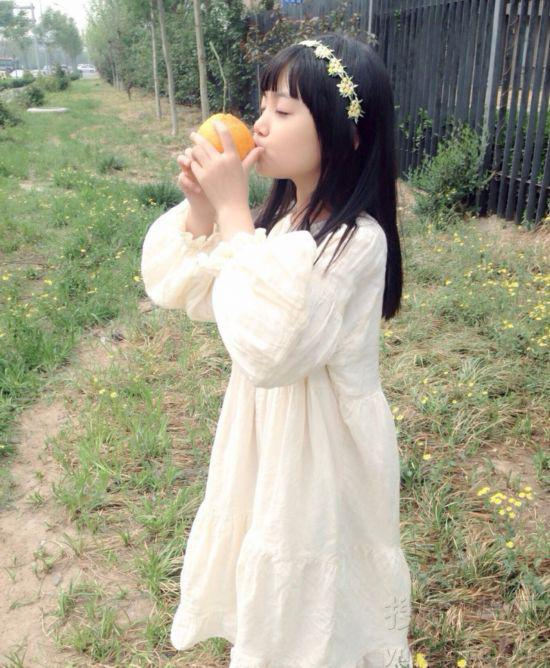

In [5]:
Image.open(img_paths[0])

In [6]:
img_captions[0]

'一个穿着裙子的女孩双手拿着东西站在宽阔的草地上'

# 加载CLIP模型

In [7]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained(r"D:\Download\AI-ModelScope\chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained(r"D:\Download\AI-ModelScope\chinese-clip-vit-base-patch16") # 预处理

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# 图像编码

In [9]:
from sklearn.preprocessing import normalize

# img_captions: 图像标签
# img_paths: 图像路径
img_image_feat = [] # 图像特征

# 批处理大小
batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    if idx == 5 :
        # 100图
        break
    # break

# np.vstack()是垂直堆叠（vertical stack）函数，用于将多个数组在垂直方向（按行）堆叠成一个新的数组    
img_image_feat = np.vstack(img_image_feat)

img_image_feat = normalize(img_image_feat)

C:\Users\Hide\AppData\Local\Temp\ipykernel_29532\1401035210.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [12]:
print(img_image_feat.shape) # 20张图片 512 维度
# print(img_image_feat[0])
print(img_paths[0])
# Image.open(img_paths[0])

(120, 512)
D:\Download\asset\ai_challenger_caption_validation_20170910\caption_validation_images_20170910\0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg


# 文本编码

In [13]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

    if idx == 5 :
        # 100图
        break
    # break

# np.vstack()是垂直堆叠（vertical stack）函数，用于将多个数组在垂直方向（按行）堆叠成一个新的数组    
img_texts_feat = np.vstack(img_texts_feat)

# from sklearn.preprocessing import normalize
img_texts_feat = normalize(img_texts_feat)

C:\Users\Hide\AppData\Local\Temp\ipykernel_29532\2650542585.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [14]:
img_texts_feat.shape

(120, 512)

# 尝试1：相似度计算

In [16]:
query_idx = 86

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]
print(sim_idx)

[72 81 88]


输入文本:  两个穿着相同外套的女孩和一个戴着眼镜的男孩站在室内


([], [])

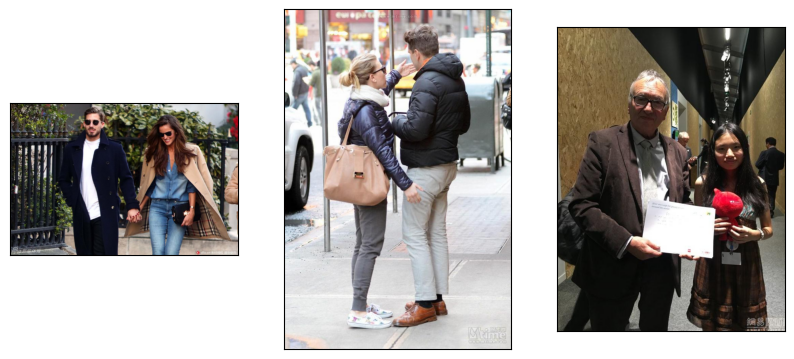

In [17]:
print('输入文本: ', img_captions[query_idx])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([]) # 当显示图片时，去掉周围的坐标轴刻度，让图片显示更干净整洁

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [18]:
query_idx = 86

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['两个人旁有一个戴着手套的女人走在室外的走廊里', '宽敞的球场上有两名运动员在交谈', '大厅里的两个人旁边站着两个穿着古装的人']


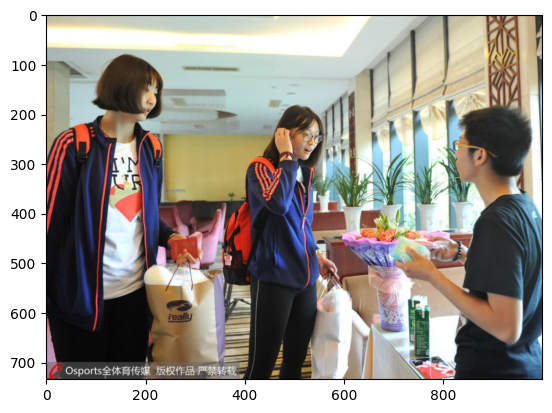

In [19]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [20]:
import jieba
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Hide\AppData\Local\Temp\jieba.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [21]:
jieba.lcut(img_captions[0])

['一个',
 '穿着',
 '裙子',
 '的',
 '女孩',
 '双手',
 '拿',
 '着',
 '东西',
 '站',
 '在',
 '宽阔',
 '的',
 '草地',
 '上']

In [22]:
# 文本标签
img_captions2words = [jieba.lcut(x) for x in img_captions]
# sum()的展平效果
img_captions2words = sum(img_captions2words, [])

In [23]:
img_captions2words[:10]

['一个', '穿着', '裙子', '的', '女孩', '双手', '拿', '着', '东西', '站']

In [24]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [25]:
# 最终得到单词集合列表
img_captions2words[:10]

['腰站', '唱歌', '左臂', '女医生', '猪圈', '海洋生物', '屋里', '小女孩', '轮船', '竹筏']

In [26]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\Hide\AppData\Local\Temp\ipykernel_29532\1150539393.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/82 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [27]:
query_idx = 86

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['各挽着', '勾肩搭背', '旁玩', '陪练', '举到', '台子上']


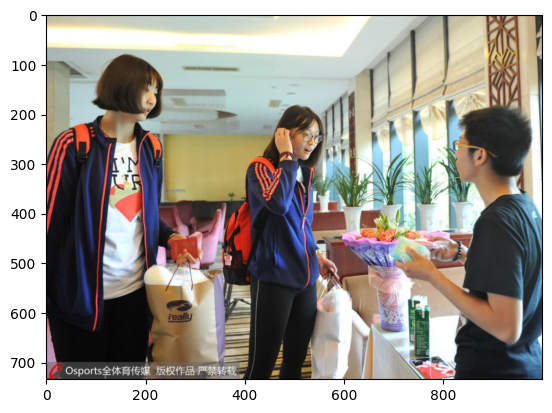

In [28]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])